<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/10_ObjectLocalization/COCO_K-Means/CocoDataset_AnchorBox_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COCO format







# YOLO Anchor boxes







# Intuition behind K-means clustering

In [49]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random

In [46]:
y!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2021-07-15 06:42:39--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.169.75
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.169.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  15.4MB/s    in 17s     

2021-07-15 06:42:57 (13.8 MB/s) - ‘annotations_trainval2017.zip.1’ saved [252907541/252907541]



In [47]:
!unzip 'annotations_trainval2017.zip'

Archive:  annotations_trainval2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/instances_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/captions_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/captions_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/person_keypoints_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/person_keypoints_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [51]:
#Read COCO JSON File
fptr = open('/content/annotations/instances_train2017.json')
data = json.load(fptr)
print(data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [68]:
n_images = len(data['images'])
n_boxes = len(data['annotations'])
n_categ = len(data['categories'])

# height, width
heights = [x['height'] for x in data['images']]
widths = [x['width'] for x in data['images']]


print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Number of images:  118287
Number of bounding boxes:  860001
Number of classes:  80
Max min avg height:  640 51 484
Max min avg width:  640 59 577


In [70]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in data['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

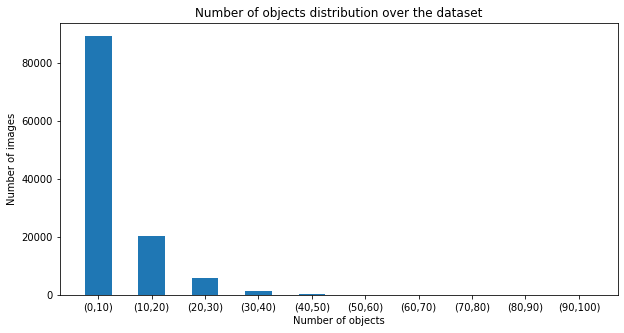

Number of images having atleast one box:  117266
Min number of boxes per image:  1
Max number of boxes per image:  93
Avg number of boxes per image:  7


In [71]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

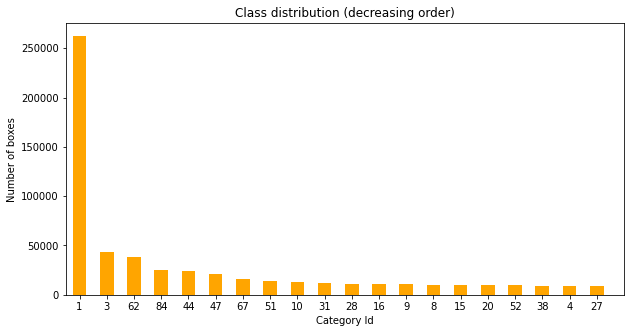

1 -> person, 2 -> bicycle, 3 -> car, 4 -> motorcycle, 5 -> airplane, 6 -> bus, 7 -> train, 8 -> truck, 9 -> boat, 10 -> traffic light, 11 -> fire hydrant, 13 -> stop sign, 14 -> parking meter, 15 -> bench, 16 -> bird, 17 -> cat, 18 -> dog, 19 -> horse, 20 -> sheep, 21 -> cow, 22 -> elephant, 23 -> bear, 24 -> zebra, 25 -> giraffe, 27 -> backpack, 28 -> umbrella, 31 -> handbag, 32 -> tie, 33 -> suitcase, 34 -> frisbee, 35 -> skis, 36 -> snowboard, 37 -> sports ball, 38 -> kite, 39 -> baseball bat, 40 -> baseball glove, 41 -> skateboard, 42 -> surfboard, 43 -> tennis racket, 44 -> bottle, 46 -> wine glass, 47 -> cup, 48 -> fork, 49 -> knife, 50 -> spoon, 51 -> bowl, 52 -> banana, 53 -> apple, 54 -> sandwich, 55 -> orange, 56 -> broccoli, 57 -> carrot, 58 -> hot dog, 59 -> pizza, 60 -> donut, 61 -> cake, 62 -> chair, 63 -> couch, 64 -> potted plant, 65 -> bed, 67 -> dining table, 70 -> toilet, 72 -> tv, 73 -> laptop, 74 -> mouse, 75 -> remote, 76 -> keyboard, 77 -> cell phone, 78 -> micro

In [74]:
# Class distribution
class2nboxes = {} 

for ann in data['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in data['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

# Class wise bounding box distribution

In [75]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in data['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

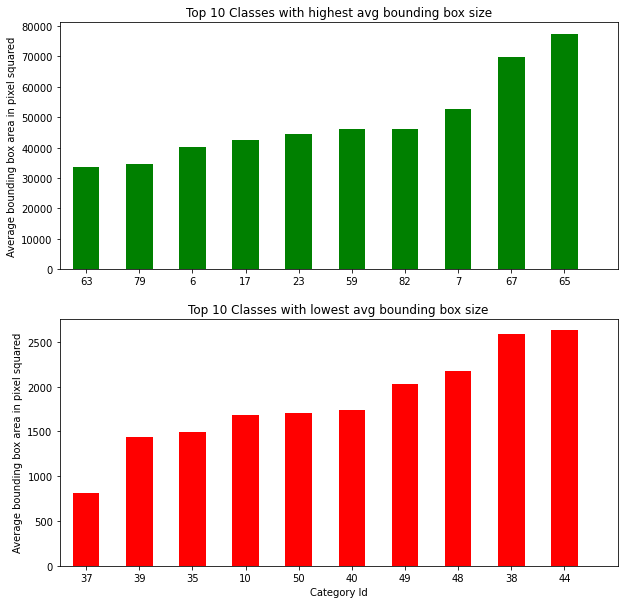

In [78]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()

# K-Means Clustering

In [52]:
#Extract Details
images_df = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations_df = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())

In [53]:
images_df.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895
1,4,000000522418.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c...,522418
2,3,000000184613.jpg,http://images.cocodataset.org/train2017/000000...,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_...,184613
3,3,000000318219.jpg,http://images.cocodataset.org/train2017/000000...,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_...,318219
4,3,000000554625.jpg,http://images.cocodataset.org/train2017/000000...,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_...,554625


In [54]:
annotations_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",2765.14865,0,558840,"[199.84, 200.46, 77.71, 70.88]",58,156
1,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",1545.42130,0,200365,"[234.22, 317.11, 149.39, 38.55]",58,509
2,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",5607.66135,0,200365,"[239.48, 347.87, 160.0, 57.81]",58,603
3,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",0.00000,0,200365,"[296.65, 388.33, 1.03, 0.0]",58,918
4,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",800.41325,0,200365,"[251.87, 333.42, 125.94, 22.71]",58,1072


In [55]:
#Extract the Box Dimensions
annotation_map_df = pd.concat([images_df, annotations_df], 1)[['file_name', 'width', 'height', 'bbox']]
x_list = []
y_list = []
w_list = []
h_list = [] 
for row in range(annotation_map_df.shape[0]):
  x = annotation_map_df['bbox'][row][0]
  y = annotation_map_df['bbox'][row][1]
  w = annotation_map_df['bbox'][row][2]
  h = annotation_map_df['bbox'][row][3]
  x_list.append(x)
  y_list.append(y)
  w_list.append(w)
  h_list.append(h)
box_df = pd.DataFrame(list(zip(x_list, y_list, w_list, h_list)), columns =['x', 'y', 'box_width', 'box_height'])
annotation_map_df = pd.concat([annotation_map_df, box_df], 1)
annotation_map_df = annotation_map_df.drop('bbox', axis =1)

In [56]:
annotation_map_df.head()

,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,199.84,200.46,77.71,70.88
1,000000522418.jpg,640.0,480.0,234.22,317.11,149.39,38.55
2,000000184613.jpg,500.0,336.0,239.48,347.87,160.00,57.81
3,000000318219.jpg,556.0,640.0,296.65,388.33,1.03,0.00
4,000000554625.jpg,426.0,640.0,251.87,333.42,125.94,22.71


In [57]:
#Normalize the Box Dimensions based on Image Height and Width
annotation_map_df['x'] = annotation_map_df['x'] / annotation_map_df['width']
annotation_map_df['y'] = annotation_map_df['y'] / annotation_map_df['height']
annotation_map_df['box_width'] = annotation_map_df['box_width'] / annotation_map_df['width']
annotation_map_df['box_height'] = annotation_map_df['box_height'] / annotation_map_df['height']

In [58]:
annotation_map_df.head()

,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,0.312250,0.556833,0.121422,0.196889
1,000000522418.jpg,640.0,480.0,0.365969,0.660646,0.233422,0.080312
2,000000184613.jpg,500.0,336.0,0.478960,1.035327,0.320000,0.172054
3,000000318219.jpg,556.0,640.0,0.533543,0.606766,0.001853,0.000000
4,000000554625.jpg,426.0,640.0,0.591244,0.520969,0.295634,0.035484


In [59]:
annotation_map_df = annotation_map_df.dropna() 

In [60]:
annotation_map_df.isnull().any()

file_name     False
width         False
height        False
x             False
y             False
box_width     False
box_height    False
dtype: bool

In [61]:
hw_array = annotation_map_df[["box_width", "box_height"]].to_numpy()

In [62]:
hw_array.shape

(118287, 2)

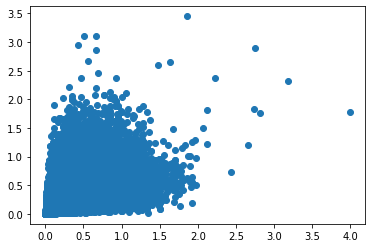

In [63]:
plt.scatter(hw_array[:,0], hw_array[:,1])

In [64]:
np.any(np.isnan(hw_array))

False

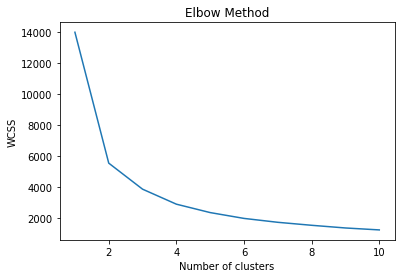

In [65]:
#Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(hw_array)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

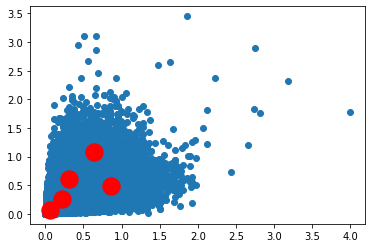

In [66]:
#Determine the optimal number of clusters
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(hw_array)
plt.scatter(hw_array[:,0], hw_array[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()